# Variational Autoencoder for S(Q)

In [1]:
# Chi-Huan Tung
# National Tsing-Hua University
# Aug 2021
#
# This notebook is based on the example of Convolutional Variational Autoencoder (CVAE)
# on tensorflow.org/tutorials/generative/cvae

In [2]:
# Use convolution layer
# Sigmoid function output from network
# ln(S(Q))

## Setup

In [3]:
from IPython import display

import glob
import imageio
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
import scipy.interpolate as interp

In [4]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

Assign device (GPU)

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [6]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Load data

### Training set

In [7]:
# minimum sq
sq_min = np.exp(-5)

In [8]:
if 1:
    X_file = '../../data/input_grid_all_GPR80.csv'
    Y_file = '../../data/target_grid_all.csv'
else:
    X_file = '../../data/input_random_all_GPR80.csv'
    Y_file = '../../data/target_random_all.csv'
    
fX = open(X_file, 'r', encoding='utf-8-sig')
sq = np.genfromtxt(fX, delimiter=',').astype(np.float32)
sq[sq<=0] = sq_min

fY = open(Y_file, 'r', encoding='utf-8-sig')
target = np.genfromtxt(fY, delimiter=',').astype(np.float32)

In [9]:
if 0:
    sq = np.vstack((sq[0:7500,:],sq))
    target = np.vstack((target[0:7500,:],target))

In [10]:
sq.shape

(18750, 80)

In [11]:
eta = target[:,0]
kappa = target[:,1]
Z = target[:,3]
A = target[:,2]
lnZ = np.log(Z)
lnA = np.log(A)

In [12]:
sq_dim = sq.shape[1]
sample_train_dim = sq.shape[0]

$Q\cdot r_\textrm{ave}$

In [13]:
q = (np.arange(sq_dim)+1)*0.2
q_rs = (np.arange(sq_dim)+1)*0.2
q_rs_dim = q_rs.shape[0]

Rescale

In [14]:
r_eta = 1
sq_rs = np.zeros((sample_train_dim,q_rs_dim),dtype='float32')
for i in range(sample_train_dim):
    qr_eta = q*r_eta
    interpolating_function = interp.interp1d(qr_eta[3:],sq[i,3:],fill_value='extrapolate')
    sq_rs[i,:] = interpolating_function(q_rs).astype(np.float32)
sq_rs[sq_rs<=0] = sq_min

### Test set

In [15]:
if 0:
    X_file = '../../data/input_grid_all_GPR80.csv'
    Y_file = '../../data/target_grid_all.csv'
else:
    X_file = '../../data/input_random_all_GPR80.csv'
    Y_file = '../../data/target_random_all.csv'
    
fX_test = open(X_file, 'r', encoding='utf-8-sig')
sq_test = np.genfromtxt(fX_test, delimiter=',').astype(np.float32)
sq_test[sq_test<=0] = sq_min

fY_test = open(Y_file, 'r', encoding='utf-8-sig')
target_test = np.genfromtxt(fY_test, delimiter=',').astype(np.float32)

In [16]:
sq_test.shape

(15000, 80)

In [17]:
eta_test = target_test[:, 0]
kappa_test = target_test[:, 1]
Z_test = target_test[:, 3]
A_test = target_test[:, 2]
lnZ_test = np.log(Z_test)
lnA_test = np.log(A_test)

In [18]:
sample_test_dim = sq_test.shape[0]

Rescale

In [19]:
r_eta_test = 1
sq_test_rs = np.zeros((sample_test_dim,q_rs_dim),dtype='float32')
for i in range(sample_test_dim):
    qr_eta = q*r_eta_test
    interpolating_function_test = interp.interp1d(qr_eta[3:],sq_test[i,3:],fill_value='extrapolate')
    sq_test_rs[i,:] = interpolating_function_test(q_rs)
sq_test_rs[sq_test_rs<=0] = sq_min

### Mask

In [20]:
mask_length = 0
sq_mask = sq_rs
sq_test_mask = sq_test_rs

for i in range(sample_train_dim):
    sq_mask[i,0:mask_length] = sq_rs[i,mask_length]
for i in range(sample_test_dim):
    sq_test_mask[i,0:mask_length] = sq_test_mask[i,mask_length]

### Preprocess/Postprocess

In [21]:
exp_scale = 3

def f_inp(sq):
    return np.log(sq)/exp_scale/2 + 0.5


def f_out(predictions):
    return np.exp((predictions*2-1)*exp_scale)

In [22]:
def to_tf(arg):
    arg = tf.convert_to_tensor(arg, dtype=tf.float32)
    return arg

## Network architecture

In [23]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, sq_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        regularizer = None
        self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(sq_dim)),
            tf.keras.layers.Reshape((sq_dim,1)),
            tf.keras.layers.Conv1D(
                filters=32, kernel_size=3, strides=2, activation='relu',
                kernel_regularizer = regularizer,
                name='conv1d_en'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(
                latent_dim + latent_dim, 
                kernel_regularizer = regularizer,
                name='dense_en'),
        ]
        )
        
        self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(
                40*32, activation=tf.nn.relu, 
                kernel_regularizer = regularizer,
                name='dense_de'),
            tf.keras.layers.Reshape(target_shape=(40, 32)),
            tf.keras.layers.Conv1DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same', activation='relu',
                kernel_regularizer = regularizer,
                name='conv1dtrs_de'),
            tf.keras.layers.Conv1DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
            tf.keras.layers.Reshape((sq_dim,))
        ]
        )
        
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(1000, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
        
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [24]:
latent_dim = 3
model = VAE(latent_dim, q_rs_dim)

## Load trained model

In [25]:
export_path = '../saved_model/SQ_cVAE_MSE_ns/'
model_name = 'model_conv_stride2_GPR'
export_name = export_path + model_name

In [26]:
reload_sm = model.load_weights(export_name, by_name=False, skip_mismatch=False, options=None)
reload_sm.__dict__

{'_checkpoint': <tensorflow.python.training.tracking.util._CheckpointRestoreCoordinator at 0x22a814a6850>,
 '_feed_dict': None,
 '_graph_view': <tensorflow.python.training.tracking.graph_view.ObjectGraphView at 0x22afe3d02b0>,
 '_root': <__main__.VAE at 0x22a8762fd00>}

In [27]:
model_r = reload_sm._root
#model_r.__dict__

## Visualize the potential parameter distributions in the space of latent variables

In [28]:
x = to_tf(f_inp(sq_test_mask))
mean, logvar = model.encode(x)
z = model.reparameterize(mean, logvar)
x_logit = model.sample(z)
z = z.numpy()    
F = z.T

U, S, Vh = np.linalg.svd(F)

In [29]:
zs = np.matmul(z,U)

for i in range(3):
    if np.abs(np.min(zs,axis = 0)[i]) > np.abs(np.max(zs,axis = 0)[i]):
        zs[:,i] = -zs[:,i]

np.std(zs,axis = 0)

array([3.569834  , 1.2168005 , 0.51736253], dtype=float32)

In [30]:
d_zs = np.max(zs,axis = 0)-np.min(zs,axis = 0)
d_z = np.max(z,axis = 0)-np.min(z,axis = 0)

In [31]:
parameters = (eta_test,kappa_test,lnA_test)
parameters_GP = np.vstack(parameters).T
index_eta = np.arange(sq_test.shape[0])

In [32]:
%matplotlib notebook

In [33]:
def generate_image_scatter(z,parameter):
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(z[index_eta,0], z[index_eta,1], z[index_eta,2], 
               c=parameter,
               s=1)
    ax.view_init(elev=25, azim=-135)
    ax.set_xlabel('lv[0]')
    ax.set_ylabel('lv[1]')
    ax.set_zlabel('lv[2]')
    ax.set_box_aspect([d_zs[0],d_zs[1],d_zs[2]])
    fig.tight_layout()

    scatter_name = './figures_SQ_cVAE_MSE_ns/lvsc3D_eta.png'
    #plt.savefig(scatter_name.format(epoch))
    plt.show()

<IPython.core.display.Javascript object>


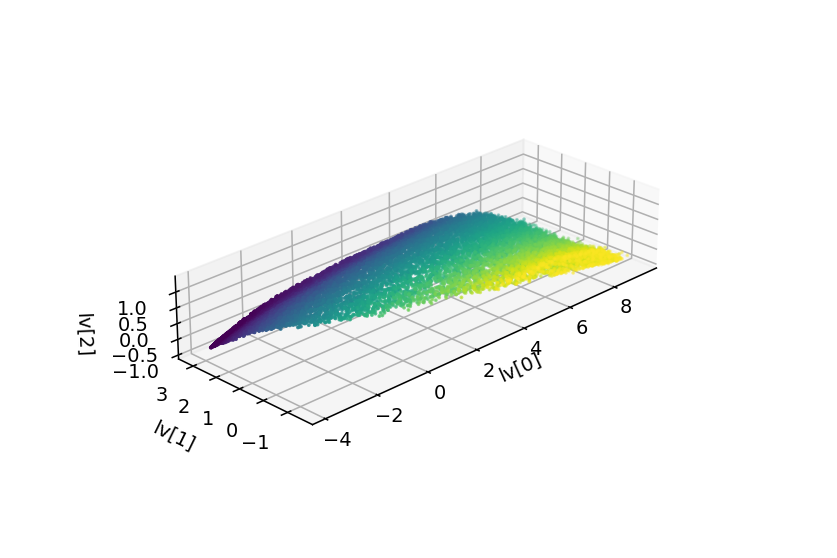

In [34]:
generate_image_scatter(zs,parameters[0][index_eta])

<IPython.core.display.Javascript object>


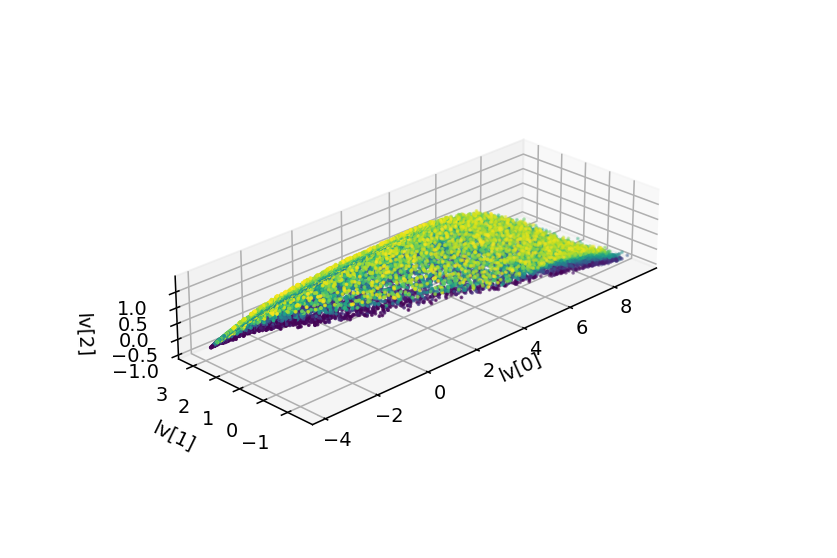

In [35]:
generate_image_scatter(zs,parameters[1][index_eta])

<IPython.core.display.Javascript object>


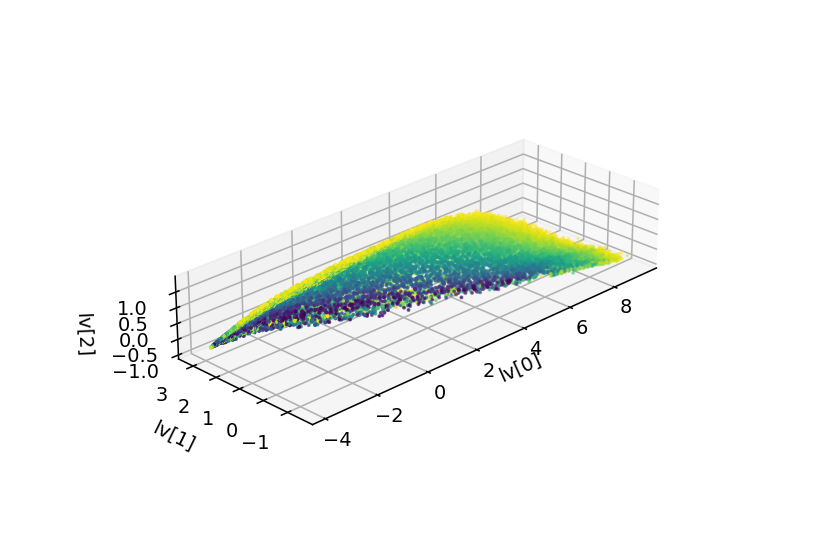

In [36]:
generate_image_scatter(zs,parameters[2][index_eta])

## GPR

Use GPR to infer the potential parameters from to the latent vatiables in `Fit_cVAE` by the `GPflow` package.

In [135]:
import gpflow
from gpflow.utilities import print_summary
from gpflow.ci_utils import ci_niter

In [136]:
k_GPR = gpflow.kernels.RBF()
meanf = gpflow.mean_functions.Zero()
#print_summary(k)

In [137]:
m_GPR = gpflow.models.GPR(data=(zs[0:1000,:].astype('float64'), parameters_GP[0:1000,:].astype('float64')), kernel=k, mean_function=meanf)
m_GPR.likelihood.variance.assign(0.01)
m_GPR.kernel.lengthscales.assign(0.3)
#print_summary(m)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=-1.0502256128148466>

In [138]:
opt = gpflow.optimizers.Scipy()

In [139]:
opt_logs = opt.minimize(m_GPR.training_loss, m_GPR.trainable_variables, options=dict(maxiter=100))
print_summary(m_GPR)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │      value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 60.6312    │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  0.475266  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │  0.0585301 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧════

In [141]:
m_GPR.predict_f_compiled = tf.function(
    m_GPR.predict_f, input_signature=[tf.TensorSpec(shape=[None, 3], dtype=tf.float64)]
    )

In [166]:
samples_input = zs[12000:12001,:].astype('float64')
original_result = m_GPR.predict_f_compiled(samples_input)

In [159]:
model_name_GPR = 'GPflow/model_GPR'
export_name_GPR = export_path + model_name_GPR
tf.saved_model.save(m_GPR, export_name_GPR)

INFO:tensorflow:Assets written to: ./saved_model/SQ_cVAE_MSE_ns/GPflow/model_GPR\assets


INFO:tensorflow:Assets written to: ./saved_model/SQ_cVAE_MSE_ns/GPflow/model_GPR\assets


In [160]:
m_GPR_loaded = tf.saved_model.load(export_name_GPR)

In [167]:
loaded_result = m_GPR_loaded.predict_f_compiled(samples_input)
loaded_result

(<tf.Tensor: shape=(1, 3), dtype=float64, numpy=array([[1.33793740e-55, 9.01950934e-55, 1.58291316e-54]])>,
 <tf.Tensor: shape=(1, 3), dtype=float64, numpy=array([[60.63122893, 60.63122893, 60.63122893]])>)

In [165]:
parameters_GP[2000:2001,:].astype('float64')

array([[0.0948    , 0.39776   , 3.01278591]])